In [1]:
import numpy as np
import ase
import glob
from matplotlib import pyplot as plt

import pandas as pd
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
from parse_density_files import CUBE
import alchemy_tools2 as at
from ase.units import Bohr
from explore_qml_data import get_num_val_elec
import os
from pyscf import gto, scf, mp, cc, dft

In /home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor 

In [ ]:
def get_EI_el(lam_vals, alchpots, nuc_charges):
    """
    inetgrate over tilde rho with respect to lambda
    """
    EI_el = []
    for i in range(len(nuc_charges)):
        EI_el.append(np.trapz(alchpots[:, i], lam_vals)*nuc_charges[i])
    return(np.array(EI_el))

def get_e_npbc(nuc_charges, positions):
    atom = []
    for a, c in zip(nuc_charges, positions*Bohr):
        atom.append([int(a), tuple(c)])

    mol = gto.Mole()
    mol.verbose = 0
    #mol.output = 'H2_{}.log'.format(d)
    mol.atom = atom
    mol.basis = 'def2tzvp'
    mol.build()

    # PBE
    mdft = dft.RKS(mol)
    mdft.xc = 'pbe'
    e_pbe = mdft.kernel()
    
    return(e_pbe)

def get_lambda(paths):
    lam_vals = []
    for p in paths:
        if 'DENSITY' in p:
            lam_vals.append(float(p.split('/')[-2][3:]))
        else:
            lam_vals.append(float(p.split('/')[-1].split('.')[0][3:]))
    
    lam_vals = np.array(lam_vals)
    lam_vals = lam_vals/lam_vals[-1]
    return(lam_vals)

def read_cube_data(paths_cubes):
    """
    returns the data necessary to calculate the atomic energies from the cube-files
    for different lambda values
    
    paths_cubes: paths to cubes files
    densities: densities given in different cube files
    lam_vals: lambda value for cube file, obtained by parsing filename
    nuclei: charges and coordinates of the nuclei
    gpts: the gridpoints where density values are given
    """
    
    densities = []
    nuclei = None # nuclear charges and their positions
    gpts = None # gridpoints where density values are given
    h_matrix = np.zeros((3,3)) # needed for the calculation of the distance of the nuclei to the gridpoints with MIC
    
    for idx, path in enumerate(paths_cubes):
        cube = CUBE(path)
        
        densities.append(cube.data_scaled) # density
        
        fname = os.path.split(path)[1] # lambda value
        fname = fname.split('.')[0]
        total_ve = get_num_val_elec(cube.atoms[:, 0])
        # check if integrates to correct number of electrons
        if not np.isclose(cube.data_scaled.sum(), total_ve):
            print(f'{path} does not integrate to correct num_ve')
        
        if idx==len(paths_cubes)-1:
            nuclei = cube.atoms
            gpts = cube.get_grid()
            h_matrix = [cube.X*cube.NX, cube.Y*cube.NY, cube.Z*cube.NZ]
    
    return(densities, nuclei, gpts, h_matrix)

def save_data(alchpots, densities, e_el, e_tot, e_npbc, e_scaled, fname, lam_vals, nuclei):
    """
        alchpots: 2D array, one row contain alchpots at one lambda value for all atoms in same order as specified in nuclei
        the lambda value increases with each row from 0 to 1

        e_el: atomic electronic energy obtained by integration along lambda for every atom in nuclei

        e_tot: addition of nuclear repulsion to e_el

        e_npbc: energy of a single point pbe calculation without pbc for the same configuration as specified in nuclei

        e_scaled: shift of e_tot such that the sum of the atomic energies is equal to the energy of e_nbpc
    """
    data = {'alchpots':alchpots, 'densities':densities, 'e_el':e_el, 'e_tot':e_tot, 'e_nbpc':e_npbc, 'e_scaled':e_scaled, 'lam_vals':lam_vals, 'nuclei':nuclei}
    uqm.save_obj(data, fname)

def scale_EI(e_alch, e_npbc, nuc_charges):
    shift = (e_npbc - e_alch.sum())/nuc_charges.sum()
    EI_scaled = []
    for e, z in zip(e_alch, nuc_charges):
        EI_scaled.append(e + z*shift)
    return(np.array(EI_scaled))

def wrapper_alchpots(densities, nuclei, meshgrid, h_matrix):
    """
    integrate electron density over r for single lambda values
    """
    alchpots = []
    for d in densities:
        out = at.calculate_atomic_energies(d, nuclei, meshgrid, h_matrix, intg_method = 'sum')
        alchpots.append(out[2])
    return(np.array(alchpots))

def wrapper_read_data(paths):
    # load data, parameters

    densities, nuclei, gpts, hmatrix = read_cube_data(paths)
    
    # get density of ueg
    num_ve = get_num_val_elec(nuclei[:, 0])
    ueg = np.zeros(gpts[0].shape)
    ueg[:] = num_ve/gpts[0].shape[0]**3
    assert np.isclose(ueg.sum(), num_ve), 'wrong ueg'
    densities.insert(0, ueg)


    lam_vals = get_lambda(paths)
    lam_vals = np.insert(lam_vals, 0, 0.0)
    
    lamval_copy = lam_vals.copy()
    lam_vals.sort()
    assert np.array_equal(lamval_copy, lam_vals), 'wrong sorting'
    
    return(densities, gpts, hmatrix, lam_vals, nuclei)

In [ ]:
def atoms_wrapper(amon):
    """
    item of amon dict
    """
    coords = []
    elements = ''
    for line in amon[2:]:
        el, x, y, z = line.split()
        coords.append([float(x),float(y),float(z)])
        elements += el
    
    atoms_object = ase.Atoms(elements, coords)
    return(atoms_object)

amons_dict = uqm.load_obj('/home/misa/datasets/amons_qm9_11k/unique_amons_dict')
butanol_text = amons_dict['CCCCO']
butanol = atoms_wrapper(butanol_text)

In [ ]:
basepath = '/home/misa/projects/Atomic-Energies/data/ueg_reference/amons'

compounds = ['amon_000001', 'amon_000010', 'amon_000036', 'amon_000138']

for comp in compounds:
    cube_dir = f'/home/misa/projects/Atomic-Energies/data/ueg_reference/amons/{comp}/cube-files'
    fname = f'/home/misa/projects/Atomic-Energies/data/ueg_reference/amons/{comp}/results.dict'
    paths = glob.glob(os.path.join(cube_dir, '*.cube'))
    paths.sort()
    densities, gpts, hmatrix, lam_vals, nuclei = wrapper_read_data(paths)
    alchpots = wrapper_alchpots(densities, nuclei, gpts, hmatrix)
    e_el = get_EI_el(lam_vals, alchpots, nuclei[:,0])
    e_tot = e_el + at.nuclear_repulsion(nuclei[:,0], nuclei[:,1:])
    e_npbc = 0 # get_e_npbc(nuclei[:,0], nuclei[:,1:])
    e_scaled = scale_EI(e_tot, e_npbc, nuclei[:,0])
    save_data(alchpots, densities, e_el, e_tot, e_npbc, e_scaled, fname, lam_vals, nuclei)

In [ ]:
e_el

### $\mu(r)$

In [2]:
def get_mu_r(n_pos, grid, hmatrix, rho_tilde, radii):
    dist = at.distance_MIC2(n_pos, grid, hmatrix)
    
    mu_r = []
    
    g_r = []
    for i in radii:
        rho_tmp = rho_tilde.copy()
        # set dens = 0 if distance > threshold
        rho_tmp[np.where(dist>i)] = 0.0
        
        mu_r.append(-(rho_tmp/dist).sum())
        
    mu_r = np.array(mu_r)
    
    return(mu_r)

def get_der_mu_r(r, mu_r):
    der_y = []
    der_x = []
    for i in range(1, len(mu_r)):
        der_x.append((r[i]+r[i-1])/2)
        der_y.append((mu_r[i]-mu_r[i-1])/(r[i]-r[i-1]))
    return(der_x, der_y)

In [43]:
basepath = '/home/misa/projects/Atomic-Energies/data/ueg_reference/amons/amon_000036'

In [44]:
cube = CUBE(f'{basepath}/cube-files/ve_08.cube')

In [45]:
results = uqm.load_obj(f'{basepath}/results.dict')

In [47]:
results['nuclei'][0:2]

array([[ 6.      , 12.84911 , 14.820297, 15.406939],
       [ 6.      , 15.269319, 16.409079, 15.435377]])

In [48]:
# calculate rho tilde
rho_tilde = np.trapz(results['densities'], results['lam_vals'], axis=0)

# get grid
grid = cube.get_grid()
hmatrix = cube.get_hmatrix()
n_pos = results['nuclei'][1, 1:]

r_i = 0.1
r_f = 12
step = 0.2

mus = []
ders = []
for n in results['nuclei'][0:2]:
    pos = n[1:]
    radii = np.arange(r_i, r_f, step)

    mu = get_mu_r(pos, grid, hmatrix, rho_tilde, radii)
    der_x, der_y = get_der_mu_r(radii, mu)
    mus.append(mu)
    ders.append([der_x, der_y])
    
uqm.save_obj(mus, os.path.join(basepath, 'mu_r'))
uqm.save_obj(ders, os.path.join(basepath, 'd_mu_r'))

In [49]:
mus = uqm.load_obj(os.path.join(basepath, 'mu_r'))
ders = uqm.load_obj(os.path.join(basepath, 'd_mu_r'))

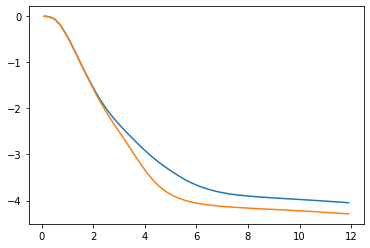

In [50]:
#radii = np.arange(0.5, 30, 0.7)
radii = np.arange(r_i, r_f, step)

for m in mus:
    plt.plot(radii, m)

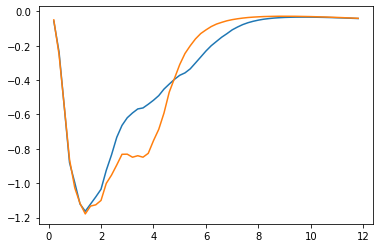

In [51]:
for d in ders:
    plt.plot(d[0], d[1])